# Homework 3

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
curr_path = os.getcwd()
parent_path = os.path.dirname(os.path.dirname(os.path.dirname(curr_path)))

raw_data = pd.read_csv(os.path.join(parent_path, r'Lectures/Lecture 3/data/hw3.csv'))

In [3]:
print(raw_data.shape)
raw_data.head()

(2667, 9)


,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,31502.151631,NaN,UNI,ETH
1,2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,73686.230000,NaN,CRV,ETH
2,2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,73736.747000,NaN,SOL,SOL
3,2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,18508.040102,NaN,ETH,ETH
4,2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,69426.909000,NaN,SOL,SOL


check data type of the raw data. It was noted that `ts` column was read in as `object` type. The field would be changed to datetime.

In [4]:
raw_data.dtypes

ts            object
open         float64
high         float64
low          float64
close        float64
volume       float64
volumeUSD    float64
token         object
chain         object
dtype: object

using the `count` function to identify the null values in the data. It was noted that `high`, `low`, `close` contains some missing values, and `volumeUSD` is entirely empty.

In [5]:
raw_data.count()

ts           2667
open         2667
high         2163
low          2378
close        2531
volume       2667
volumeUSD       0
token        2667
chain        2667
dtype: int64

### 1. Check Token and Chain
The section verifies the number of unique tokens included in the dataset and some inproper tokens (ex. `'<span name="tokenName">CRV</span>'` ) were identified. Such invalid values were cleaned.

In [6]:
raw_data['token'].unique()

array(['UNI', 'CRV', 'SOL', 'ETH', 'AAVE', 'USDT', 'COMP', 'BTC',
       '<span name="tokenName">UNI</span>',
       '<span name="tokenName">CRV</span>',
       '<span name="tokenName">SOL</span>',
       '<span name="tokenName">USDT</span>',
       '<span name="tokenName">COMP</span>',
       '<span name="tokenName">AAVE</span>',
       '<span name="tokenName">ETH</span>',
       '<span name="tokenName">BTC</span>'], dtype=object)

In [7]:
raw_data['chain'].unique()

array(['ETH', 'SOL', 'USDT', 'BTC'], dtype=object)

In [8]:
chains = raw_data['chain'].unique()

In [9]:
# check token and chain pairs - XXX and <span name="tokenName">XXX</span> match to the same chain
raw_data[['token','chain']].drop_duplicates()

,token,chain
0,UNI,ETH
1,CRV,ETH
2,SOL,SOL
3,ETH,ETH
6,AAVE,ETH
7,USDT,USDT
16,COMP,ETH
20,BTC,BTC
45,"<span name=""tokenName"">UNI</span>",ETH
71,"<span name=""tokenName"">CRV</span>",ETH


In [10]:
# clean '<span name="tokenName">XXX</span>'

clean_data = raw_data.copy()
clean_data['token'] = clean_data['token'].apply(lambda x: x.strip("""<span name="tokenName">""").strip("</span>"))
clean_data[['token','chain']].drop_duplicates()

,token,chain
0,UNI,ETH
1,CRV,ETH
2,SOL,SOL
3,ETH,ETH
6,AAVE,ETH
7,USDT,USDT
16,COMP,ETH
20,BTC,BTC


### 2. Check Duplicated Rows

In [11]:
clean_data = clean_data.sort_values(by='ts')
tokens = clean_data['token'].unique()

for token in tokens:
    print("{}: length = {}, unique dates = {}".format(token, len(clean_data[clean_data['token']==token]), len(clean_data[clean_data['token']==token]['ts'].unique())))


SOL: length = 334, unique dates = 295
COMP: length = 332, unique dates = 295
AAVE: length = 328, unique dates = 295
UNI: length = 342, unique dates = 295
BTC: length = 337, unique dates = 295
ETH: length = 326, unique dates = 295
USDT: length = 333, unique dates = 295
CRV: length = 335, unique dates = 295


In [12]:
clean_data = clean_data.drop_duplicates()

In [13]:
for token in tokens:
    print("{}: length = {}, unique dates = {}".format(token, len(clean_data[clean_data['token']==token]), len(clean_data[clean_data['token']==token]['ts'].unique())))

SOL: length = 295, unique dates = 295
COMP: length = 295, unique dates = 295
AAVE: length = 295, unique dates = 295
UNI: length = 295, unique dates = 295
BTC: length = 295, unique dates = 295
ETH: length = 295, unique dates = 295
USDT: length = 295, unique dates = 295
CRV: length = 295, unique dates = 295


### 3. Convert Dates to Datetime type
Convert dates and find the date range

In [14]:
clean_data['ts'] = pd.to_datetime(clean_data['ts'])
print(clean_data.ts.max())
print(clean_data.ts.min())

2021-12-13 06:00:00
2021-12-01 00:00:00


In [15]:
clean_data.ts.dtype

dtype('<M8[ns]')

In [16]:
clean_data = clean_data.set_index('ts')

### 4. Treat Invalid Values in Close Price
checking for NaN values and Outlier in the data

#### check missing values

In [17]:
clean_data[clean_data.close.isnull()].groupby('token').count()

,open,high,low,close,volume,volumeUSD,chain
token,,,,,,,
AAVE,19,15,17,0,19,0,19
BTC,9,7,9,0,9,0,9
COMP,15,13,13,0,15,0,15
CRV,12,10,12,0,12,0,12
ETH,15,13,13,0,15,0,15
SOL,13,9,12,0,13,0,13
UNI,14,12,13,0,14,0,14
USDT,19,13,17,0,19,0,19


Given 'chain' column is 100% populated, the number under the 'chain' column represents the total number null values (NaN) in 'close'. 'close' and 'volumeUSD' shows 0 for all token means all value selected by `clean_data[clean_data.close.isnull()]` is NaN. Note that 'high' and 'low' does not add up to the same value as in 'open', 'volume' and 'chain'. This showns that when 'close' value is NaN, a few 'high' and 'low' also has NaN.

#### check relevancy between missing values for each token
Concat the missing fields for each token to exam the distribution of NaN in close price. It was noticed that these NaN values happens at random time in a day and there was no connection between each token.

In [18]:
df = pd.DataFrame()
for token in tokens:
    temp = clean_data[clean_data['token']==token]
    temp = temp[temp['close'].isnull()]['token'].to_frame(name=token)
    df = pd.concat([df,temp], axis=1)
df

,SOL,COMP,AAVE,UNI,BTC,ETH,USDT,CRV
ts,,,,,,,,
2021-12-01 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRV
2021-12-01 07:00:00,NaN,NaN,NaN,NaN,NaN,ETH,NaN,NaN
2021-12-01 12:00:00,NaN,NaN,AAVE,NaN,NaN,NaN,NaN,NaN
2021-12-01 16:00:00,NaN,NaN,AAVE,NaN,NaN,NaN,NaN,NaN
2021-12-01 18:00:00,NaN,NaN,NaN,NaN,BTC,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-12-12 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,USDT,NaN
2021-12-12 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,USDT,NaN
2021-12-13 00:00:00,NaN,NaN,AAVE,NaN,NaN,NaN,NaN,NaN


In [19]:
import matplotlib.pyplot as plt
from functools import reduce

%matplotlib inline

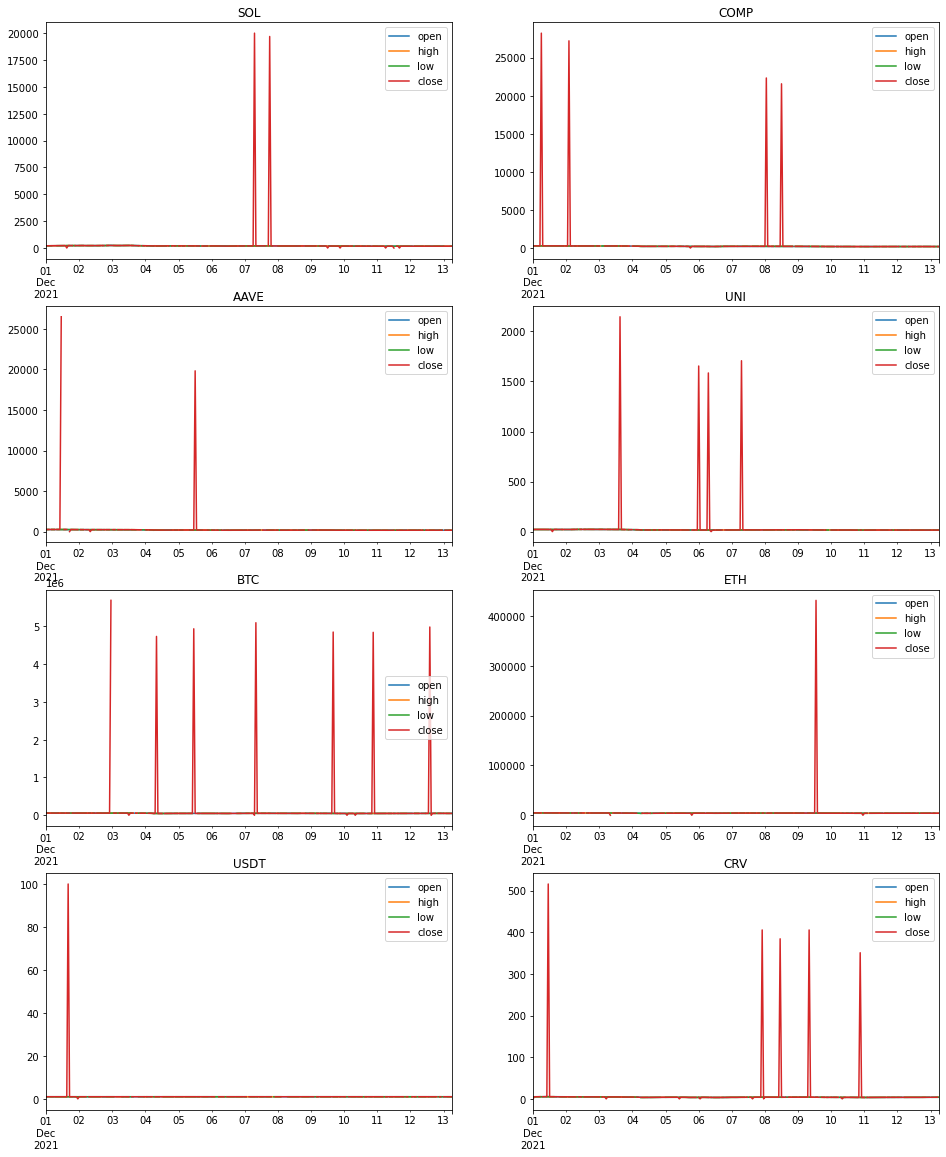

In [20]:
def plot_prices(prices, style):
    fig, axes = plt.subplots(4, 2, figsize=(16, 20))
    for i in range(len(tokens)):
        temp = clean_data[clean_data['token']==tokens[i]]
        temp[prices].plot(ax=axes[i//2][i%2], style=style)
        axes[i//2][i%2].set_title(tokens[i])
        axes[i//2][i%2].axes.set_xlabel("")
plot_prices(['open','high','low','close'],'-')

Extremely high prices were observed in all tokens

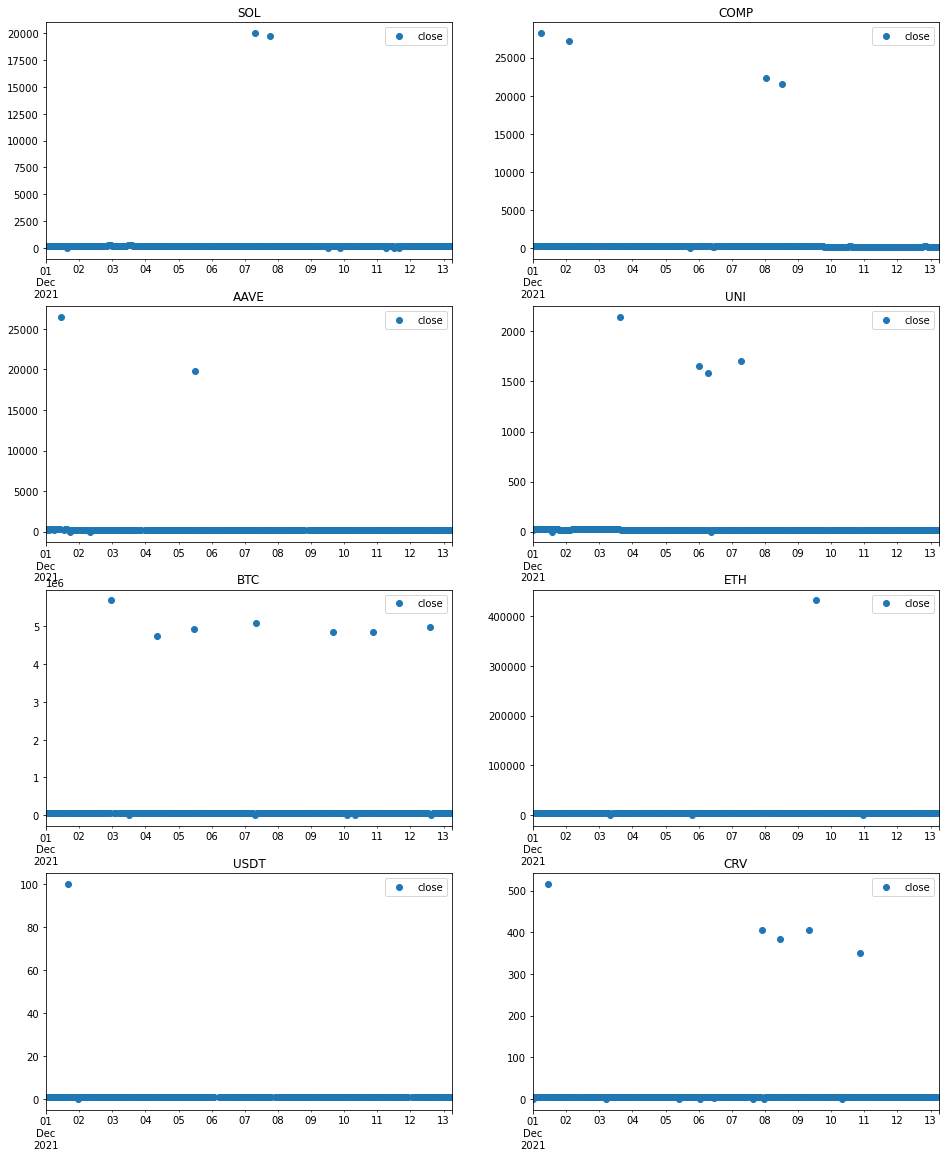

In [21]:
plot_prices(['close'],'o')

Extremely low prices were observed in all tokens

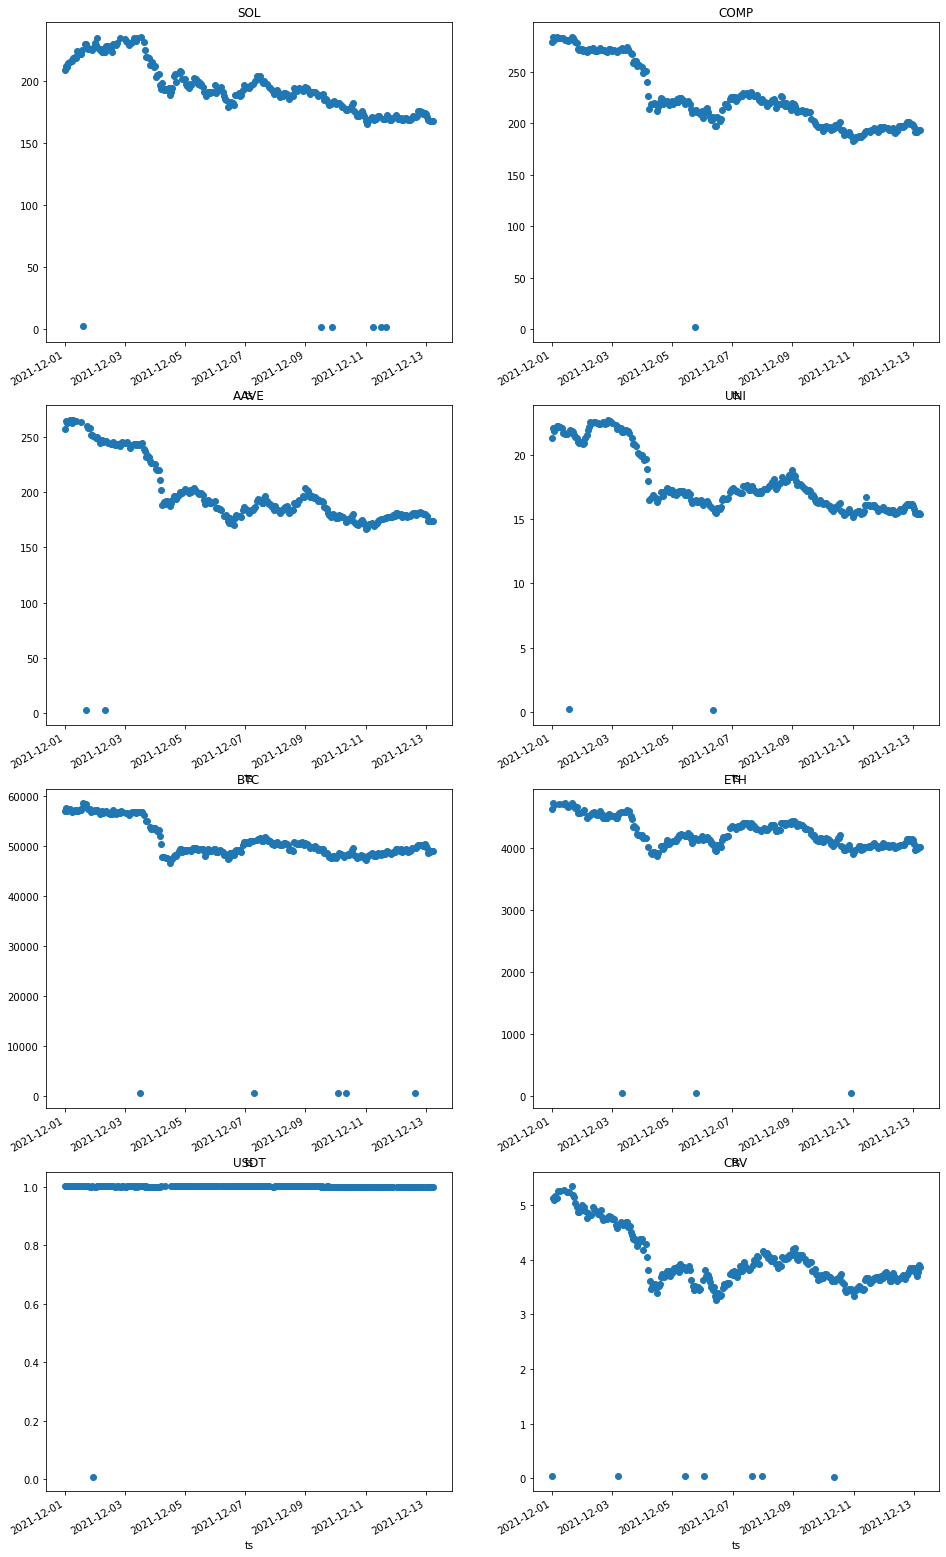

In [22]:
fig, axes = plt.subplots(4, 2, figsize=(16, 30))
for i in range(len(tokens)):
    temp = clean_data[clean_data['token']==tokens[i]]
    temp = temp[temp['close']<np.nanpercentile(temp['close'], 97.5)]
    temp['close'].plot(ax=axes[i//2][i%2], style='o')
    axes[i//2][i%2].set_title(tokens[i])

In [23]:
clean_data[['token','close']].groupby('token').describe().T

token                AAVE           BTC          COMP         CRV  \
close count    276.000000  2.860000e+02    280.000000  283.000000   
      mean     364.670071  1.717696e+05    575.071661   11.127169   
      std     1972.551902  7.705806e+05   2946.599831   54.446417   
      min        2.467160  4.768632e+02      2.145100    0.035700   
      25%      178.900000  4.865738e+04    197.475000    3.640000   
      50%      189.269500  4.953276e+04    218.765000    3.808400   
      75%      203.645500  5.347901e+04    251.497500    4.270750   
      max    26501.500000  5.688883e+06  28222.000000  516.100000   

token                  ETH           SOL          UNI        USDT  
close count     280.000000    282.000000   281.000000  276.000000  
      mean     5737.055104    330.800901    42.781755    1.356350  
      std     25512.843627   1653.395209   209.935199    5.965581  
      min        39.613200      1.700800     0.159170    0.010005  
      25%      4057.682500    178.565000    16.070000    1.000600  
      50%      4201.120000    191.729500    17.132600    1.000900  
      75%      4406.817500    208.410000    20.052600    1.001100  
      max    431046.000000  20010.000000  2145.880000  100.100000

In [24]:
temp = clean_data[clean_data['token']=='CRV']
temp[temp['close']>np.nanpercentile(temp['close'],98)]

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01 08:00:00,5.2426,NaN,5.2176,5.3948,435101.04,NaN,CRV,ETH
2021-12-01 11:00:00,5.2728,5.2882,5.1510,516.1000,245918.33,NaN,CRV,ETH
2021-12-07 22:00:00,3.9266,4.1266,3.9146,405.7400,759105.76,NaN,CRV,ETH
2021-12-08 11:00:00,3.9238,3.9745,3.8301,384.4500,206167.00,NaN,CRV,ETH
2021-12-09 08:00:00,4.0880,4.1152,3.9977,405.7000,178724.81,NaN,CRV,ETH
2021-12-10 21:00:00,3.4600,3.5100,3.4600,351.0000,108024.48,NaN,CRV,ETH


In [25]:
temp[temp['close']<np.nanpercentile(temp['close'],3)]

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01 00:00:00,4.8830,5.0723,4.8264,0.050295,339580.96,NaN,CRV,ETH
2021-12-03 05:00:00,4.5835,NaN,4.5533,0.046530,88072.82,NaN,CRV,ETH
2021-12-05 10:00:00,3.8692,3.8692,3.7310,0.037671,178982.52,NaN,CRV,ETH
2021-12-06 01:00:00,3.6302,3.6365,3.4638,0.035758,422791.26,NaN,CRV,ETH
2021-12-06 10:00:00,3.4895,NaN,3.2993,3.328200,764153.75,NaN,CRV,ETH
2021-12-06 11:00:00,3.3301,3.3872,3.2475,3.264600,489119.82,NaN,CRV,ETH
2021-12-07 15:00:00,3.8254,3.8761,3.8000,0.038411,151907.12,NaN,CRV,ETH
2021-12-07 23:00:00,4.0575,4.1472,3.9908,0.040037,661429.30,NaN,CRV,ETH
2021-12-10 08:00:00,3.5900,3.6300,3.5400,0.035700,103453.97,NaN,CRV,ETH


From above examples, it was noticed that the outliers were either 100 times greater than the reasonable close price or 100 times lesser than the reasonable close price. Hence, the following lines modifies these outliers by either divided by 100 or times by 100 to adjust to the reasonable price range.

In [26]:
clean_data.loc[clean_data['close']>10*clean_data['open'],'close'] = clean_data[clean_data['close']>10*clean_data['open']]['close']/100
clean_data.loc[clean_data['close']<0.1*clean_data['open'],'close'] = clean_data[clean_data['close']<0.1*clean_data['open']]['close']*100

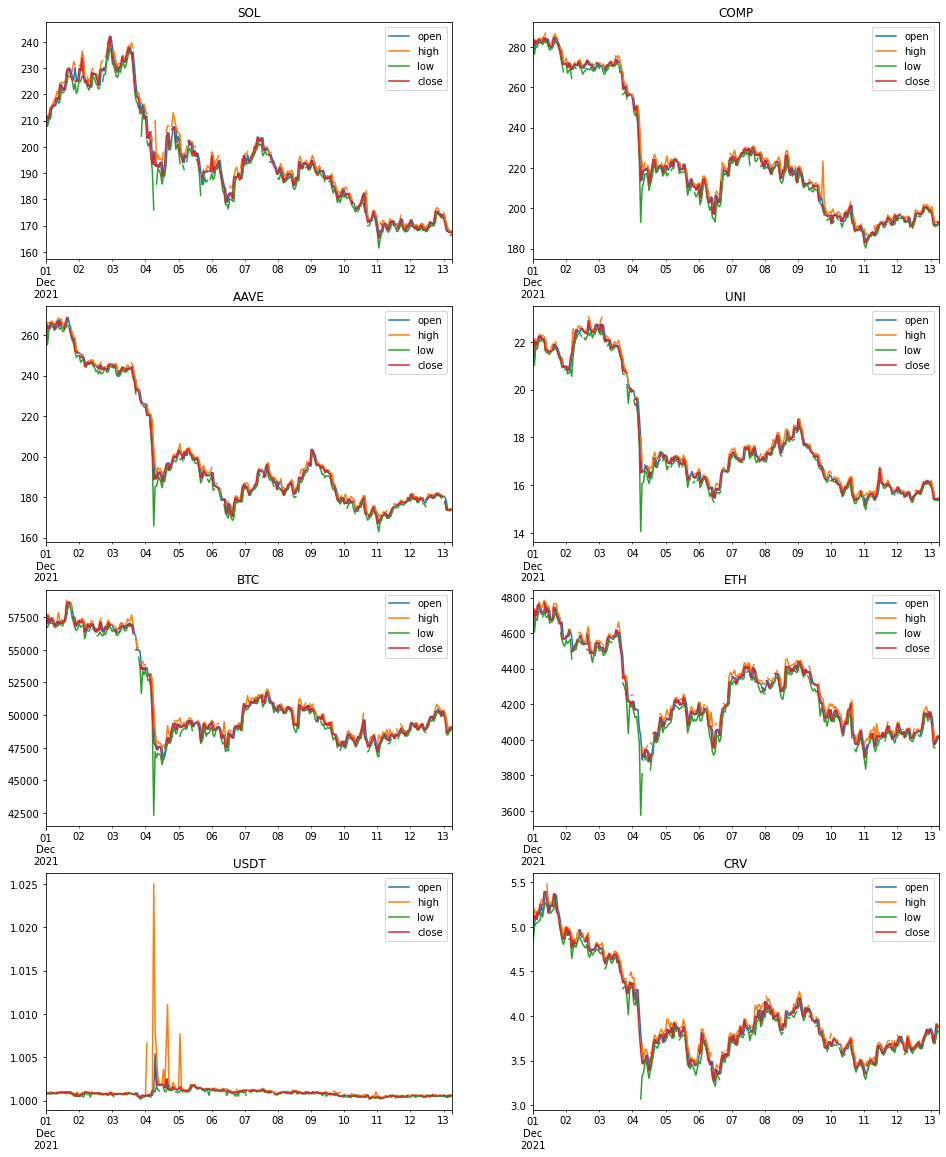

In [27]:
plot_prices(['open','high','low','close'],'-')

#### Fill NaN values

To best approximate the missing values in 'close' column, 1) the 'open' price at the next timestamp for the token was used to approximate the missing 'close' prices; 2) if 'open' price at the next timestamp was not available, the mean of 'high' price and 'low' price at the timestamp was used for missing 'close' prices. Note that missing 'high' prices and 'low' prices were approximated by 'open' prices at the corresponding timestamps.

In [28]:
clean_data.loc[clean_data['high'].isnull(), 'high'] = clean_data.loc[clean_data['high'].isnull(), 'open'] 
clean_data.loc[clean_data['low'].isnull(), 'low'] = clean_data.loc[clean_data['low'].isnull(), 'open'] 

In [29]:
for token in tokens:
    clean_data.loc[clean_data['token']==token,'next_open'] = clean_data.loc[clean_data['token']==token,'open'].shift(-1)
    clean_data.loc[(clean_data['token']==token) & (clean_data['close'].isnull()),'close'] = clean_data.loc[(clean_data['token']==token) & (clean_data['close'].isnull()),'next_open']
    na_count = len(clean_data.loc[(clean_data['token']==token) & (clean_data['close'].isnull()),'close'])
    print(f"{token}: still missing {na_count}")
    if na_count > 0:
        print('filled NaN using mean of open and close price.')
        clean_data.loc[(clean_data['token']==token) & (clean_data['close'].isnull()),'close'] = \
            0.5*clean_data.loc[(clean_data['token']==token) & (clean_data['close'].isnull()),'high'] + \
            0.5*clean_data.loc[(clean_data['token']==token) & (clean_data['close'].isnull()),'low']

SOL: still missing 0
COMP: still missing 0
AAVE: still missing 0
UNI: still missing 0
BTC: still missing 0
ETH: still missing 0
USDT: still missing 0
CRV: still missing 1
filled NaN using mean of open and close price.


In [30]:
clean_data.count()

open         2360
high         2360
low          2360
close        2360
volume       2360
volumeUSD       0
token        2360
chain        2360
next_open    2352
dtype: int64

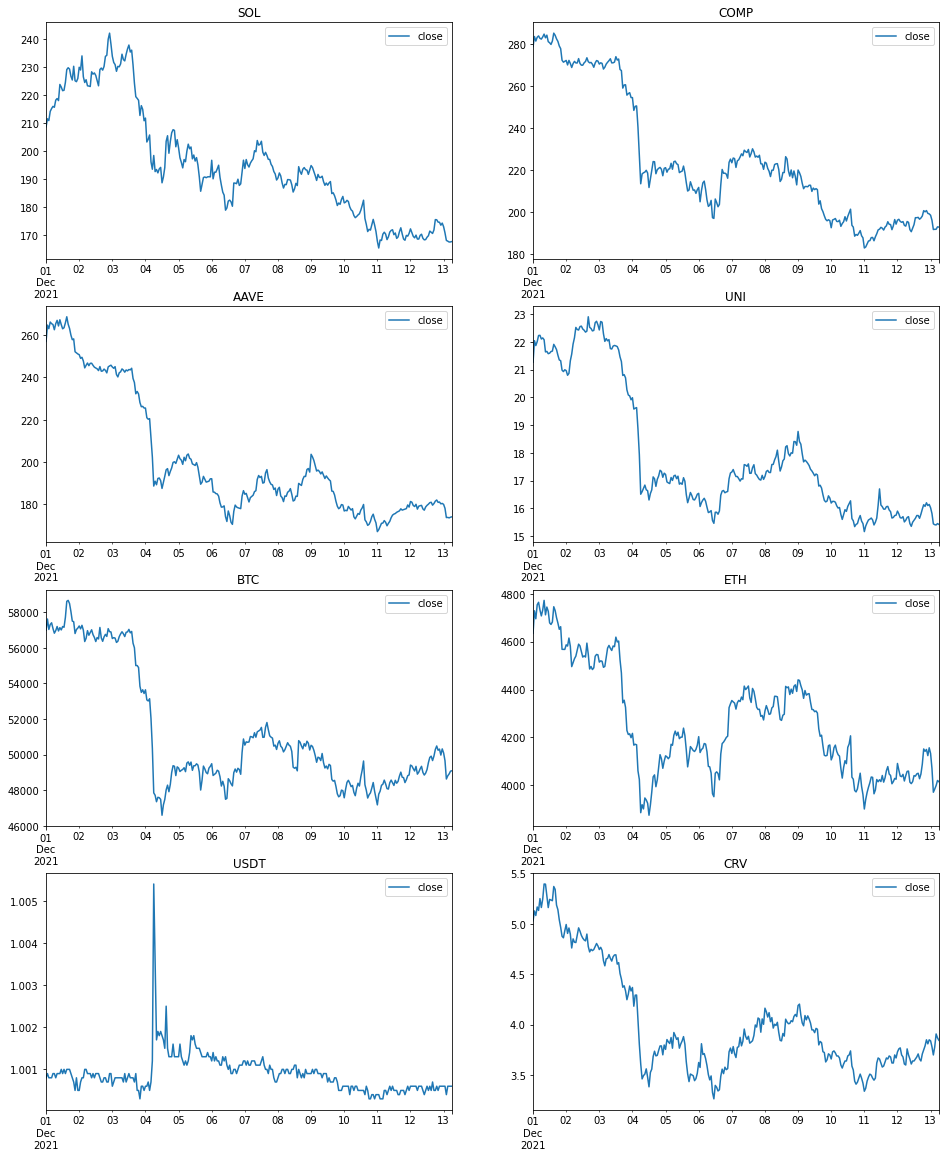

In [31]:
plot_prices(['close'],'-')

### 5. Calculate VolumeUSD
Based on cleaned data, `volumeUSD` column was calcuated and analysed by `token` and `chain`.

In [32]:
clean_data['volumeUSD'] = clean_data['close']*clean_data['volume']

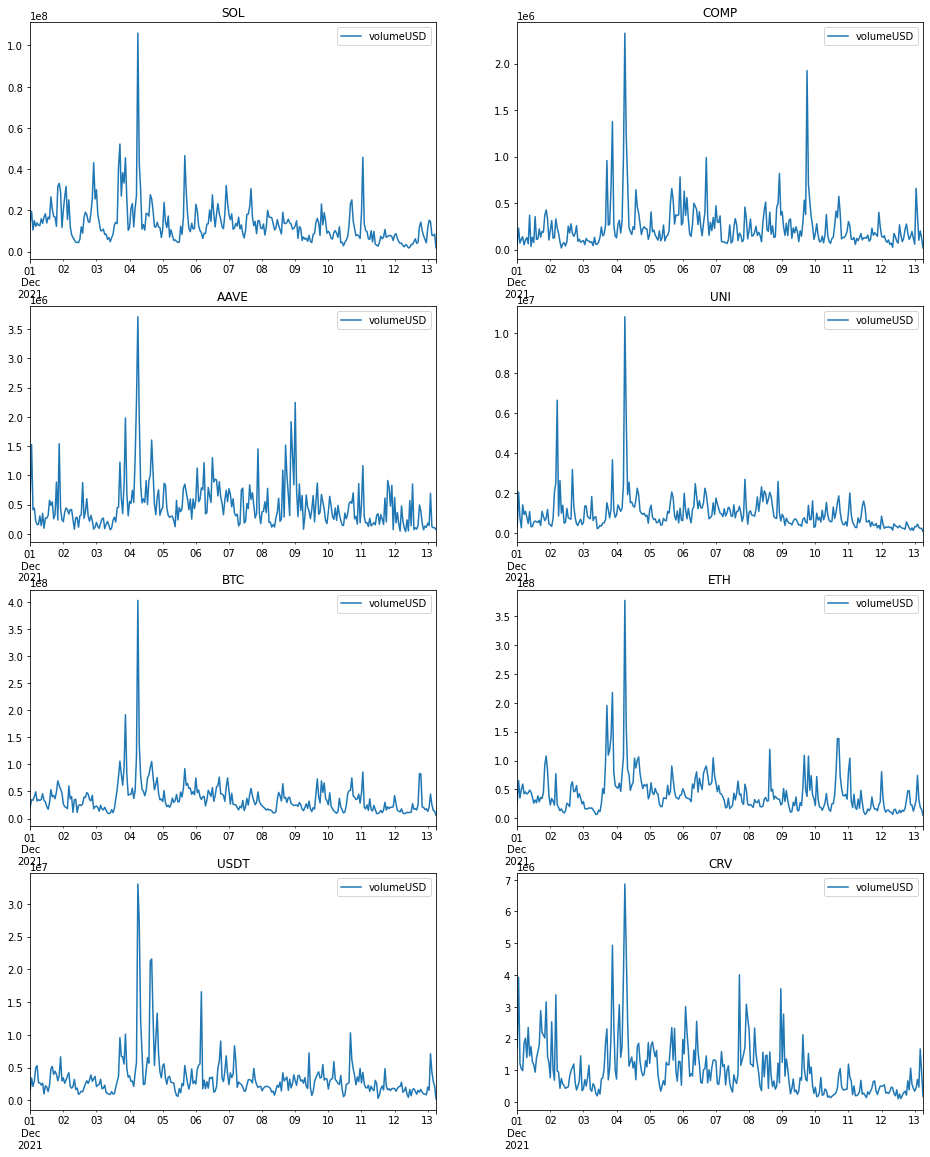

In [33]:
# plot volumeUSD by token
plot_prices(['volumeUSD'],'-')

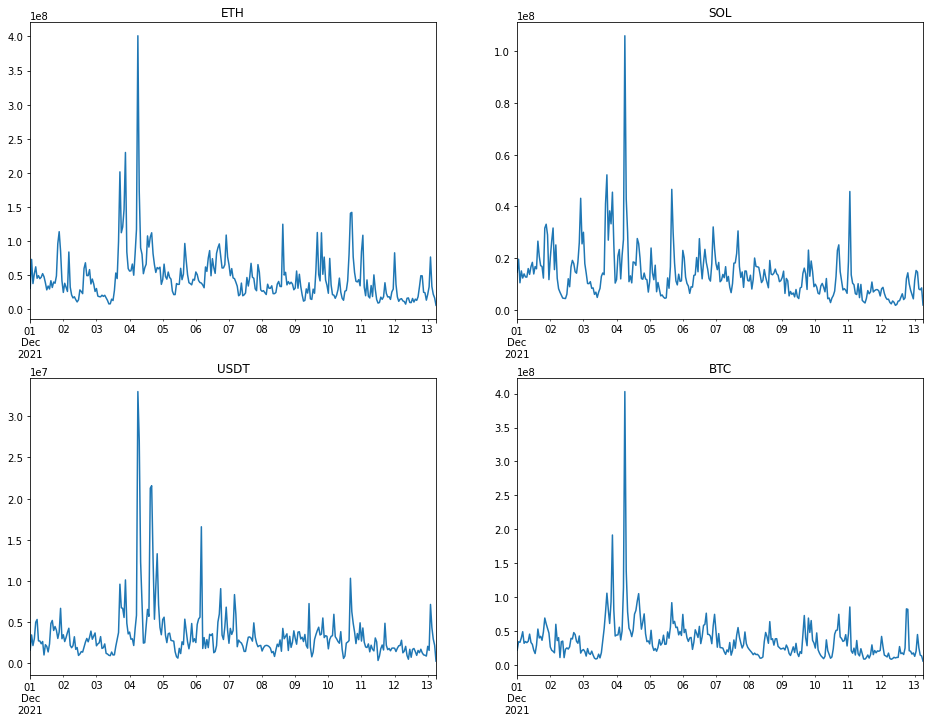

In [34]:
#plot volumeUSD by Chain
res = clean_data.groupby(['ts','chain']).sum().volumeUSD.to_frame()
res = res.reset_index(level=['chain'])
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for i in range(len(chains)):
    temp = res[res['chain']==chains[i]]
    temp['volumeUSD'].plot(ax=axes[i//2][i%2], style='-')
    axes[i//2][i%2].set_title(chains[i])
    axes[i//2][i%2].axes.set_xlabel("")


Sum of volumeUSD by token

In [35]:
clean_data.groupby('token').sum().volumeUSD.to_frame(name='volumeUSD (mm)').divide(10**6).round(2)

,volumeUSD (mm)
token,
AAVE,143.43
BTC,10959.05
COMP,72.84
CRV,308.52
ETH,12841.22
SOL,4078.21
UNI,289.90
USDT,1008.00


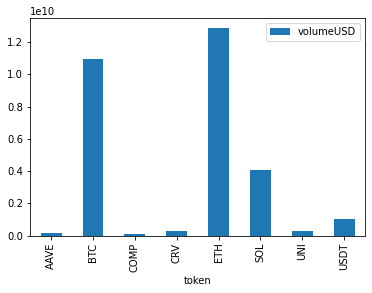

In [36]:
clean_data.groupby('token').sum().volumeUSD.to_frame().plot.bar()
plt.show()

Sum of volumeUSD by Chain

In [37]:
clean_data.groupby('chain').sum().volumeUSD.to_frame(name='volumeUSD (mm)').divide(10**6).round(2)

,volumeUSD (mm)
chain,
BTC,10959.05
ETH,13655.90
SOL,4078.21
USDT,1008.00


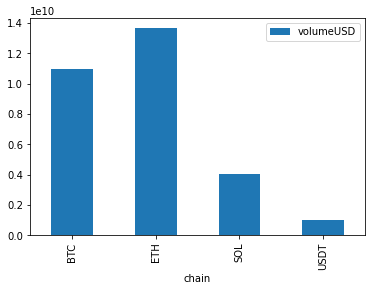

In [38]:
clean_data.groupby('chain').sum().volumeUSD.to_frame().plot.bar()
plt.show()